# 1. Importing Required Libraries

In [29]:
import warnings
warnings.simplefilter('ignore')

import nltk
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Data Ingestion

In [3]:
df = pd.read_csv('Artifacts/spam.csv', encoding='latin1')

# 3. Exploratory Data Analysis

In [4]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [8]:
df.rename(columns={'v1':'Target','v2':'Message'},inplace=True)

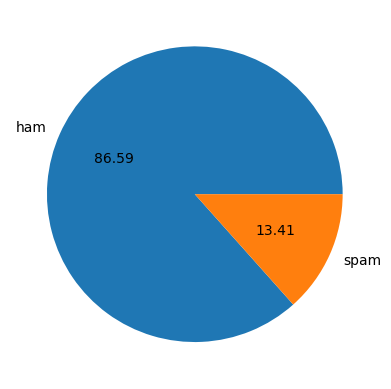

In [9]:
plt.pie(df['Target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

# 4. Data Pre-processing

### 4.1 Handling Missing Values

In [10]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

### 4.2 Handling Duplicate Records

In [11]:
df.duplicated().sum()

403

In [12]:
df = df.drop_duplicates(keep='first')

In [13]:
df.shape

(5169, 2)

### 4.3 Label Encoding

In [14]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])

### 4.4 Text Preprocessing

In [15]:
stemmer = PorterStemmer()

In [16]:
def transform_text(text):
    text = nltk.word_tokenize(text.lower())
    text = [stemmer.stem(word) for word in text if word.isalnum()]
    text = [word for word in text if word not in stop_words and word not in string.punctuation]

    return " ".join(text)

In [17]:
df['Transformed_Text'] = df['Message'].apply(transform_text)

### 4.5 Feature Engineering

In [19]:
preprocessor = TfidfVectorizer(max_features=3000)

In [20]:
df['Transformed_Text'] = preprocessor.fit_transform(df['Transformed_Text']).toarray()

### 4.6 Training and Testing Data Preparation

In [21]:
x = df['Transformed_Text'] 
y = df['Target'].values

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_test = pd.DataFrame(x_test)
x_test = pd.DataFrame(x_test)

In [23]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5169,) (5169,)
(4135, 1) (4135, 1)
(1034, 1) (1034,)


# 5. Modelling

### 5.1 Model Training

In [32]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XG Boost': XGBClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier()
}

In [33]:
model_list = []
train_accuracy_list = []
test_accuracy_list = []

for model_name, model in models.items():

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    model_list.append(model_name)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    print("=" * 50)

max_accuracy_index = test_accuracy_list.index(max(test_accuracy_list))
print(f"\nThe best model based on testing accuracy is {model_list[max_accuracy_index]} with: {test_accuracy_list[max_accuracy_index]}")

Model: Logistic Regression
Training Accuracy: 0.8773881499395405
Testing Accuracy: 0.8588007736943907
Model: Decision Tree
Training Accuracy: 0.8788391777509069
Testing Accuracy: 0.8597678916827853
Model: Random Forest
Training Accuracy: 0.8788391777509069
Testing Accuracy: 0.8597678916827853
Model: Support Vector Machine
Training Accuracy: 0.8788391777509069
Testing Accuracy: 0.8597678916827853
Model: Naive Bayes
Training Accuracy: 0.8788391777509069
Testing Accuracy: 0.8597678916827853
Model: Gradient Boosting
Training Accuracy: 0.8788391777509069
Testing Accuracy: 0.8597678916827853
Model: XG Boost
Training Accuracy: 0.8773881499395405
Testing Accuracy: 0.8588007736943907
Model: Extra Trees Classifier
Training Accuracy: 0.8788391777509069
Testing Accuracy: 0.8597678916827853

The best model based on accuracy is Decision Tree with Testing Accuracy: 0.8597678916827853


In [34]:
results = {
    'Model': model_list,
    'Train Accuracy': train_accuracy_list,
    'Test Accuracy': test_accuracy_list,
}

results = pd.DataFrame(results).sort_values(by=['Test Accuracy'], ascending=False)
results

,Model,Train Accuracy,Test Accuracy
1,Decision Tree,0.878839,0.859768
2,Random Forest,0.878839,0.859768
3,Support Vector Machine,0.878839,0.859768
4,Naive Bayes,0.878839,0.859768
5,Gradient Boosting,0.878839,0.859768
7,Extra Trees Classifier,0.878839,0.859768
0,Logistic Regression,0.877388,0.858801
6,XG Boost,0.877388,0.858801


In [35]:
param_grid = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l1', 'l2']},
    'Decision Tree': {'criterion': ['gini', 'entropy'],'max_depth': [None, 5, 10, 15, 20],'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150, 200],'max_depth': [5, 10, 15, 20],'criterion': ['gini', 'entropy']},
    'Support Vector Machine': {'C': [0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
    'Naive Bayes': {},
    'Gradient Boosting': {'n_estimators': [50, 100, 150, 200],'learning_rate': [0.01, 0.1],'max_depth': [3, 5, 7, 9]},
    'XG Boost': {'learning_rate': [0.01, 0.1],'n_estimators': [50, 100, 150, 200],'max_depth': [3, 5, 7, 9]},
    'Extra Trees Classifier': {'n_estimators': [50, 100, 150, 200],'max_depth': [5, 10, 15, 20],'criterion': ['gini', 'entropy']}
}

In [37]:
modelss = []
train_accuracies = []
test_accuracies = []


for model_name, model in models.items():
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1)

        grid_search.fit(x_train, y_train)
        best_model_cv = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {model_name}: {best_params}")

        y_train_pred = best_model_cv.predict(x_train)
        y_pred = best_model_cv.predict(x_test)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)

        modelss.append(model_name)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Train Accuracy for {model_name}: {train_accuracy}")
        print(f"Test Accuracy for {model_name}: {test_accuracy}")
        print("=" * 50)

best_test_accuracy_index = test_accuracies.index(max(test_accuracies))
print(f"\nWe got {modelss[best_test_accuracy_index]} as the model with the highest test accuracy of {test_accuracies[best_test_accuracy_index]}")

Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Train Accuracy for Logistic Regression: 0.8788391777509069
Test Accuracy for Logistic Regression: 0.8597678916827853
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Train Accuracy for Decision Tree: 0.8788391777509069
Test Accuracy for Decision Tree: 0.8597678916827853
Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}
Train Accuracy for Random Forest: 0.8788391777509069
Test Accuracy for Random Forest: 0.8597678916827853
Best parameters for Support Vector Machine: {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy for Support Vector Machine: 0.8788391777509069
Test Accuracy for Support Vector Machine: 0.8597678916827853
Best parameters for Naive Bayes: {}
Train Accuracy for Naive Bayes: 0.8788391777509069
Test Accuracy for Naive Bayes: 0.8597678916827853
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'm

In [31]:
results1 = {
    'Model': modelss,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Precision': precisions,
    'Recall (Sensitivity)': recalls,
    'F1 Score': f1_scores,
    'Specificity': specificities,
    'ROC AUC Score': roc_auc_scores
}
results1 = pd.DataFrame(results1).sort_values(by=['Test Accuracy', 'Precision', 'Recall (Sensitivity)'], ascending=False)
results1

,Model,Train Accuracy,Test Accuracy,Precision,Recall (Sensitivity),F1 Score,Specificity,ROC AUC Score
0,Logistic Regression,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
1,Decision Tree,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
2,Random Forest,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
3,Support Vector Machine,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
4,Naive Bayes,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
5,Gradient Boosting,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
7,Extra Trees Classifier,0.878839,0.859768,1.0,0.006849,0.013605,1.0,0.503425
6,XG Boost,0.877388,0.858801,0.0,0.000000,0.000000,1.0,0.500000


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model in models.items():
    y_score = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    ax.plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (model_name, roc_auc))

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
best_model_name = model_list[max_accuracy_index]
best_model = models[best_model_name]

pickle.dump(preprocessor,open('Spam_Preprocessor.pkl','wb'))
pickle.dump(best_model,open('Spam_Model.pkl','wb'))